In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split,StratifiedKFold,KFold,GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer,OneHotEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score,recall_score

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

# Reproduciblity

In [2]:
np.random.seed(59)

# Load data

In [3]:
df_train = pd.read_csv('train.csv',na_values="-1")

In [4]:
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
df_train.shape

(595212, 59)

# Understand the target

The objective is to find the probability that a driver will initiate an auto insurance claim in the next year. So before I deep dive into the data and machine learning, I want to have a rough idea about the target. 

In [6]:
'''Rating: Continuous or discrete?'''
df_train.target.value_counts()

0    573518
1     21694
Name: target, dtype: int64

In [7]:
'''Contains nan or not'''
df_train.target.isnull().values.any()

False

So the target label is imbalanced in the training data. It does not have any null value and is a binary output.

# Choose the metric

There are a lot of different metrics for an imbalanced classification problem such as precision, recall or area under the ROC curve. I will evaluate these metrics during the modeling. However in this competition they are using a metric call Normalized Gini Coefficient. The competition has posted the code for this metric. So I will evaluate my model base on all these metrics.

In [8]:
'''gini calculation
   https://www.kaggle.com/the1owl/forza-baseline'''
def gini(y, pred):
    fpr, tpr, thr = roc_curve(y, pred, pos_label=1)
    g = 2 * auc(fpr, tpr) -1
    return g

# Understand the data

There are 59 columns in the dataset. Id column is not useful for modeling so drop it. Except for the target column, the remaining columns need some more attentions.

In [9]:
df_train.drop(['id'], axis = 1, inplace = True)

In [10]:
'''Take a closer look at the remaining columns'''
summary = df_train.describe(include = 'all')
summary.T

,count,mean,std,min,25%,50%,75%,max
target,595212.0,0.036448,0.187401,0.000000,0.000000,0.000000,0.000000,1.000000
ps_ind_01,595212.0,1.900378,1.983789,0.000000,0.000000,1.000000,3.000000,7.000000
ps_ind_02_cat,594996.0,1.359799,0.663193,1.000000,1.000000,1.000000,2.000000,4.000000
ps_ind_03,595212.0,4.423318,2.699902,0.000000,2.000000,4.000000,6.000000,11.000000
ps_ind_04_cat,595129.0,0.416992,0.493062,0.000000,0.000000,0.000000,1.000000,1.000000
ps_ind_05_cat,589403.0,0.419038,1.350023,0.000000,0.000000,0.000000,0.000000,6.000000
ps_ind_06_bin,595212.0,0.393742,0.488579,0.000000,0.000000,0.000000,1.000000,1.000000
ps_ind_07_bin,595212.0,0.257033,0.436998,0.000000,0.000000,0.000000,1.000000,1.000000
ps_ind_08_bin,595212.0,0.163921,0.370205,0.000000,0.000000,0.000000,0.000000,1.000000
ps_ind_09_bin,595212.0,0.185304,0.388544,0.000000,0.000000,0.000000,0.000000,1.000000


The first thing I see is null/empty value in the data. The count for some of the columns are not the same as the count for the target column. 

In [11]:
null_columns = [i for i in summary.columns if summary[i]['count'] != 595212]
null_columns

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_reg_03',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_05_cat',
 'ps_car_07_cat',
 'ps_car_09_cat',
 'ps_car_11',
 'ps_car_12',
 'ps_car_14']

The column names are doing a great job on defining the date type for that particular column. Different data type requires some different imputation strategy. For 'cat'(categorical) I will treat null as a distinct category. For continuous variable, I will impute the null to the median.

In [12]:
for i in null_columns:
    if 'cat' in i:
        df_train[i].fillna((df_train[i].max()+1),inplace = True)
    else:
        df_train[i].fillna(df_train[i].median(), inplace = True)

By just looking at the summary I don't see any obviou sign of outliers so I will keep it that way. 

# EDA

First look at the numeric columns and their correlations

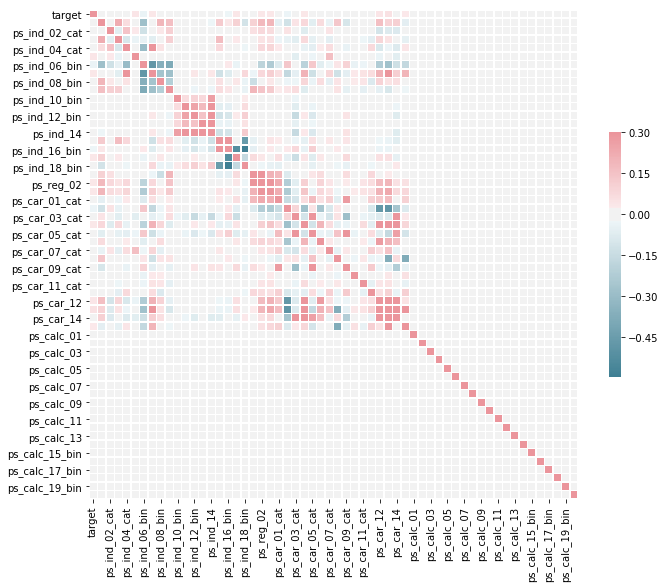

In [13]:
corrmat = df_train.select_dtypes(include = np.number).corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrmat,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This is very interesting, all the features label 'ps_calc_' have no correlation with other features what so ever. And there is no strong correlation between any of the two features. It looks like all the 'calc' columns are very independent I feel like I can just drop them.

In [14]:
calc_column = [i for i in df_train.columns if 'calc' in i]
df_train.drop(calc_column,axis = 1, inplace=True)

I will first take a look at features which has 'bin' in it. Clearly they are binary featues. I will plot them w.r.t the target to see if they have any clear predictive power

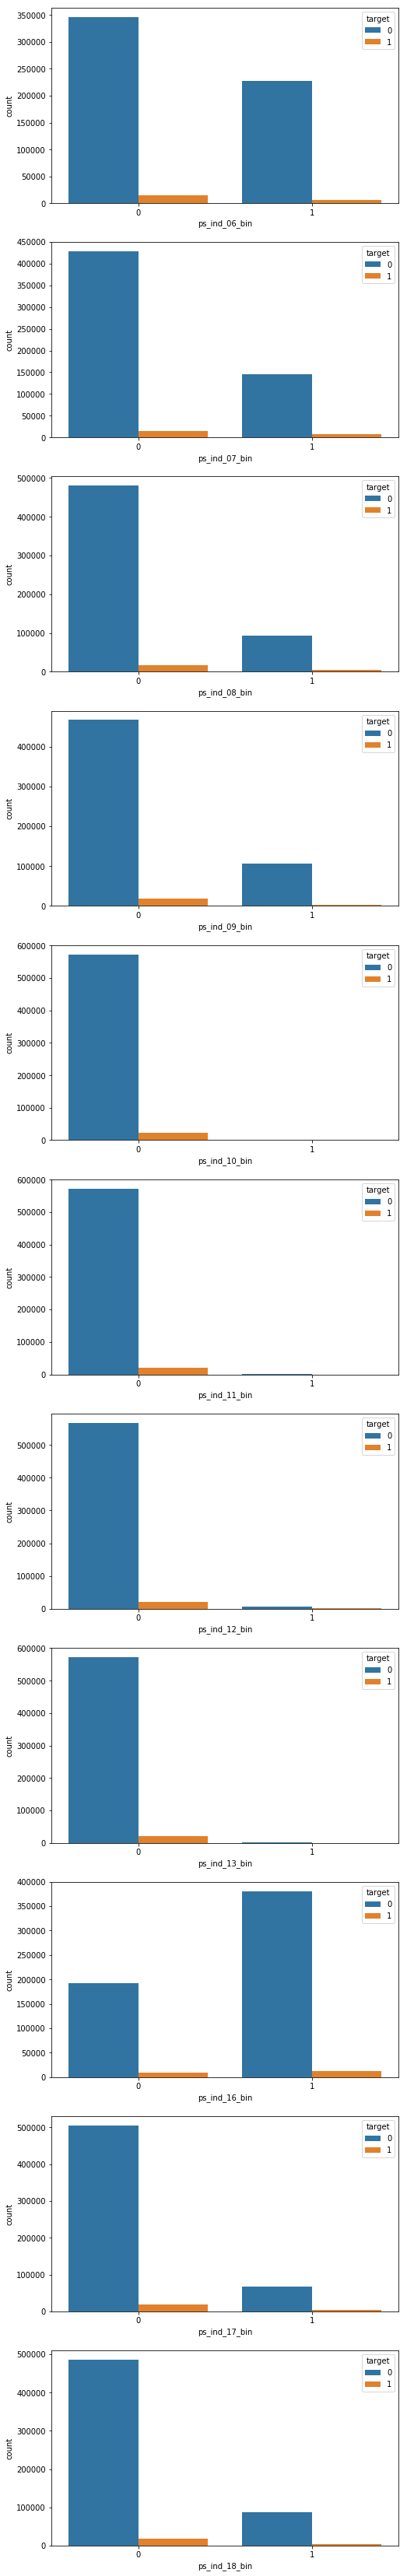

In [15]:
bi_columns = [i for i in df_train.columns if 'bin' in i]

f, ax = plt.subplots(len(bi_columns), figsize = (8,60))
for i, j in zip(bi_columns, ax):
    sns.countplot(df_train[i], hue = df_train.target, ax = j)

Some columns obviously do not provide any useful informations to the model. The number of '1's in these columns are so small as if they are not influencing the target. Such columns are 'ps_ind_10_bin', 'ps_ind_13_bin'. I will drop them for now.

In [16]:
df_train.drop(['ps_ind_10_bin','ps_ind_13_bin'],axis = 1, inplace=True)

Then I will focus myself on the 'cat' columns which stands for multi class categorical. Plot them w.r.t target for some general idea.

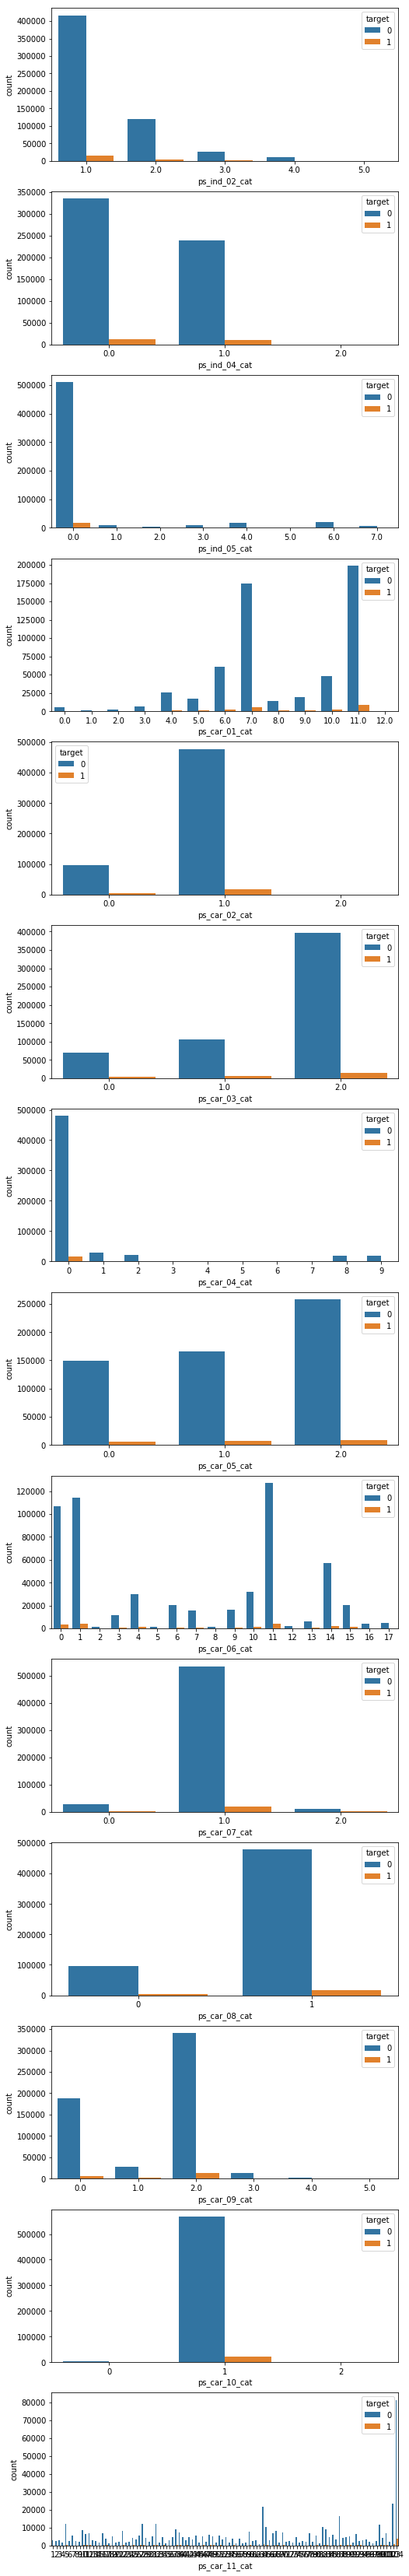

In [17]:
c_columns = [i for i in df_train.columns if 'cat' in i]
f, ax = plt.subplots(len(c_columns), figsize = (8,60))
for i, j in zip(c_columns, ax):
    sns.countplot(df_train[i], hue = df_train.target, ax = j)

Noticed some of the 'new' classes created earlier in some features contains very less information and will probabily distract the model. Such features includes 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_09_cat'. These records are only a small portion of the total data so I decided to drop them to reduce the class size for certain features.

In [18]:
mask = ((df_train['ps_ind_02_cat'] != df_train['ps_ind_02_cat'].max()) & 
        (df_train['ps_ind_04_cat'] != df_train['ps_ind_04_cat'].max()) &
        (df_train['ps_car_01_cat'] != df_train['ps_car_01_cat'].max()) &
        (df_train['ps_car_02_cat'] != df_train['ps_car_02_cat'].max()) &
        (df_train['ps_car_09_cat'] != df_train['ps_car_09_cat'].max()))
print((len(df_train) - sum(mask))/len(df_train))

0.0012802161246749059


In [19]:
df_train = df_train[mask]

Also noticed that 'ps_car_10_cat' basically has all the mass on class '1' and will hardly influence the model. I decided to drop it as well.

In [20]:
df_train.drop('ps_car_10_cat', axis = 1, inplace = True)

Lastly, 'ps_car_11_cat' has so many categories, this will seriously impact the dimension when one hot encoded. I will see if I can just cheat it as continuous variable.

In [21]:
df_train['ps_car_11_cat'].describe()

count    594450.000000
mean         62.209745
std          33.009127
min           1.000000
25%          32.000000
50%          65.000000
75%          93.000000
max         104.000000
Name: ps_car_11_cat, dtype: float64

In [22]:
df_train = df_train.rename({'ps_car_11_cat':'ps_car_11_num'})

Convert all the 'cat', 'bin' features to 'object'

In [23]:
bin_cat = [i for i in df_train.columns if ('bin' in i) | ('cat' in i)]
for i in bin_cat:
    df_train[i] = df_train[i].astype('object')

# Model

In [24]:
'''Divide the data into X and Y'''
Y = df_train['target']
X = df_train.drop('target', axis = 1)

Random forest is very good at handling a mix of continuous variable and discrete variables. Also it is insensitive to scaling. So before I do any preprocessing or advance modeling, I want to fit a simple random forest and use its ability to recognize feature importance to try to reduce the feature space a little more.

In [25]:
reducer = RandomForestClassifier()
reducer.fit(X,Y)
ranking = [(i,j) for i,j in zip(X.columns,reducer.feature_importances_)]    

In [26]:
ranking = sorted(ranking, key = lambda x: x[1])

Looking at the last few least important features, I decided to use .01 as my cutoff. I may come back to this number to increase of decrease the number of features. But right now I will use .01.

In [27]:
not_important = [i[0] for i in ranking if i[1] < .01]
X.drop(not_important,axis = 1, inplace=True)

#### Train-Test split

Use train test split to divide them into hold-out set and testing set. Hold-out set will be used for training and testing set will be used for testing

In [28]:
'''divide the data into a training set and testing set'''
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

#### preprocessing

In this dataset, some of the features are categorical and some of them are numerical with different scale. They need different treatment before putting into a model. I will build a single pipeline to combine this two together.  

In [29]:
def preprocessing(numeric_index,
                 categorical_index,
                 numeric_transformer,
                 categorical_transformer):
    pre_processor = FeatureUnion(transformer_list = [        
                        #numeric
                        ('numeric_variables_processing', Pipeline(steps = [
                            ('selecting', FunctionTransformer(lambda data: data[:,numeric_index])),
                            ('scaling', numeric_transformer)])),
                        #categorical
                        ('categorical_variables_processing', Pipeline(steps = [
                            ('selecting', FunctionTransformer(lambda data: data[:,categorical_index])),
                            ('OneHot', categorical_transformer)]))])
    return pre_processor

In [30]:
n_column = X_train.dtypes != 'object'
c_column = X_train.dtypes == 'object'
pre = preprocessing(n_column,
                    c_column,
                    StandardScaler(),
                    OneHotEncoder())

#### Upsampling

Remember at the very begining I have shown that target is extremely unbalanced. We need to balance the training data otherwise the model will most likely fail to recognize the minority class. Here I decided to use SMOTE upsampling. 

In [31]:
upsampler = SMOTE()

#### Modeling

This is a binary classification problem. So a regular classification algorithm should be sufficient for the base model. Here I decided to use Logistic Regression as my base case since I can use regularizer to reduce my training dimension during training.

In [32]:
model = LogisticRegression()

#### Put everything together

In [33]:
def model_pipeline(preprocessor,
                   sampler,
                   model):
    return Pipeline_imb([('preprocessor',preprocessor),
                         ('sampler', sampler),
                         ('model',model)])

In [34]:
estimator = model_pipeline(pre,
                           upsampler,
                           model)
estimator.fit(X_train, Y_train)
predict = estimator.predict(X_test)
prob = estimator.predict_proba(X_test)

#### Evaluate the model

In [35]:
def get_metric(p, Y):
    '''function to generate metrics given probabilities'''
    print('confusion matrix')
    print(confusion_matrix(Y, p))
    print('--------------------------------------')
    precision = precision_score(p,Y)
    recall = recall_score(p, Y)
    print('precision {:.3f} and recall {:.3f}'.format(precision, recall))
    g = gini(Y, p)
    print('gini {:.3f}'.format(g))

In [36]:
get_metric(predict, Y_test)

confusion matrix
[[85587 57633]
 [ 2383  3010]]
--------------------------------------
precision 0.558 and recall 0.050
gini 0.156


In [37]:
def AUROC(y_score, y_test):
    '''function to generate metrics given probabilites for the 
       target class'''
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,lw=2,
             label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

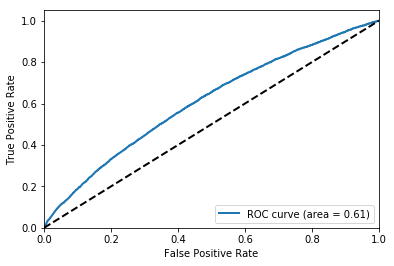

In [38]:
AUROC(prob[:,1], Y_test)

Clearly the result is not so good with some very low metric score. So a linear model may not be a good choice. I will use a tree based model this time. Remember last time random forest was used as a feature reduction tool. This time I will check its performance as well. Random forest is not sensitive to scaling and can handle categorical so no need to do any preprocessing. I will just use SMOTE and the model to build the pipeline

In [39]:
rf_estimator = Pipeline_imb([('smote', SMOTE()),('model', RandomForestClassifier())])

In [40]:
rf_estimator.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('smote', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [41]:
rf_predict = rf_estimator.predict(X_test)
rf_prob = rf_estimator.predict_proba(X_test)

In [42]:
get_metric(rf_predict, Y_test)

confusion matrix
[[143128     92]
 [  5385      8]]
--------------------------------------
precision 0.001 and recall 0.080
gini 0.001


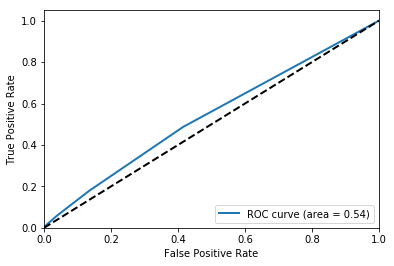

In [43]:
AUROC(rf_prob[:,1], Y_test)

This somehow perform worse that logistic regression, I will do a grid search on the random forest to see if things improved.Rebuild the pipeline to include a grid search on random forest.

In [44]:
X_res, Y_res = SMOTE().fit_sample(X_train, Y_train)
rf_grid = GridSearchCV(RandomForestClassifier(), 
                       param_grid={'n_estimators':[9,10,11],
                                   'max_depth':[2,3,4]},
                       cv = 2)
rf_grid.fit(X_res,Y_res)

GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [9, 10, 11], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
rf_grid.best_params_

{'max_depth': 4, 'n_estimators': 9}

In [46]:
rf_grid_predict = rf_grid.best_estimator_.predict(X_test)
rf_grid_prob = rf_grid.best_estimator_.predict_proba(X_test)

In [47]:
get_metric(rf_grid_predict, Y_test)

confusion matrix
[[108274  34946]
 [  3772   1621]]
--------------------------------------
precision 0.301 and recall 0.044
gini 0.057


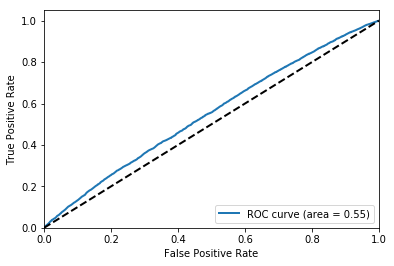

In [48]:
AUROC(rf_grid_prob[:,1], Y_test)

Still none of the model work particular well. At last I will use K-fold to average the prediction for 5 different gradient boosted model on different subset of data.

In [63]:
def kfold_model(X_train, Y_train, X_test,Y_test):
    skf = StratifiedKFold(5)
    prob_k = np.zeros(shape = (len(Y_test), 2))
    for i, (train_index, test_index) in enumerate(skf.split(X_train, Y_train)):
        x_train, x_valid = X_train[train_index], X_train[test_index]
        y_train, y_valid = Y_train[train_index], Y_train[test_index]
        gbc = GradientBoostingClassifier()
        gbc.fit(x_train, y_train)
        prob_k += gbc.predict_proba(X_test)
    prob_k /= 5
    predict_k = np.argmax(prob_k, axis = 1)
    return prob_k, predict_k

In [64]:
sm = SMOTE()
x_res, Y_res = sm.fit_sample(X_train, Y_train)
prob_k, predict_k = kfold_model(X_res, Y_res, X_test, Y_test)

In [65]:
get_metric(predict_k, Y_test)

confusion matrix
[[143214      6]
 [  5393      0]]
--------------------------------------
precision 0.000 and recall 0.000
gini -0.000


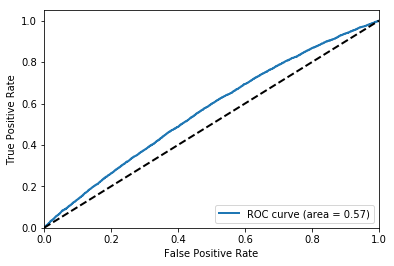

In [66]:
AUROC(prob_k[:,1], Y_test)

# Conclusion

All these models are not producing very good results. All the tree based model have been prouducing outputs biasly towards the 0 class. Whereas a linear model does balance the output a little bit but has sacrificing a lot on the precision/recall on the 0 class. 

For future improvement, I would say a more in depth feature engineering can be done to extract some more predictive features. The winning kaggler actually use a autoencoder to encoder the features to extract better feature that reduce noise. And in terms of model choice, since logistic regression seem to be working better than other tree based models, I will probabily try an mlp approach which is sort of like a logistic regression but with some non-linearity introduced. And in terms of metric, precision and recall for the 1 class should be a very good metric in a business sense. 